In [79]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import json
import shutil
import math


#pip install analytic_wfm
from analytic_wfm.peakdetect import *
import cloudpickle
from datetime import datetime
import time

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

%run "Fonctions.ipynb"
%run "Signal.ipynb"

In [3]:
# Copie des fichiers .event pour aide export en .txt
copy_event_file("..\Millau\Resultats")
# copy_event_file("..\Normandie")

In [4]:
# Sélection des meilleurs signaux pour chacun des camions représentés par un fichier .txt
trucks_millau = select_all_best_signal('../Millau/Resultats/All_event', backup_path="backup/backup_trucks_millau.json")
# trucks_normandie = select_all_best_signal('../Normandie/All_event', backup_path="backup/backup_trucks_normandie.json")

In [5]:
# Récupération des csv contenant les informations de charges
millau = pd.read_csv('../Millau/Resultats/Fichiers Excel/millau_df_model.csv', index_col=0)
# normandie = pd.read_csv('../Normandie/Fichiers Excel/normandie_df_model.csv', index_col=0)

In [6]:
# Trouver les correspondances entre les nswd et les event
trucks_coor_millau = find_trucks_in_csv(trucks_millau, millau, "backup_trucks_coor_millau.json")
# trucks_coor_normandie = find_trucks_in_csv(trucks_normandie, normandie, "backup_trucks_coor_normandie.json

In [7]:
# Création des class Signal
trucks_sig_millau = create_signal_instance(trucks_coor_millau, filename="class_trucks_millau.sig")
#trucks_sig_normandie = create_signal_instance(trucks_coor_normandie, filename="class_trucks_normandie.sig")

In [66]:
# Création DataFrame global Millau
all_df = pd.DataFrame()
for key, value in trucks_sig_millau.items():
    all_df = pd.concat([all_df, value.to_df()], sort=True)
all_df = all_df.reset_index(drop=True).sort_index()

Le pic 4.9707 du signal 2017-06-20-12-31-25-246 a eu un problème sur le calcul des fwhms.
Le pic 4.86133 du signal 2017-06-21-14-31-28-257 a eu un problème sur le calcul des fwhms.


In [67]:
# Remplacer 'max' par 1
all_df.replace(to_replace='max', value=1, inplace=True)

# Remplacer 'min' par 2
all_df.replace(to_replace='min', value=2, inplace=True)

In [68]:
all_df = pd.concat([timestamp_dummies(all_df['name']), all_df], axis=1)
all_df.drop(['name'], axis=1, inplace = True)

In [69]:
#Normalisation des données
#all_df = all_df.apply(lambda x: (x-x.mean())/x.std())

In [70]:
# Complétion NaN
all_df.fillna(0, inplace=True)

## Test de modèle

### Découpage train/test

In [71]:
loads = list_multiple_var('load_', var_to=8)
Y = all_df[loads]
X = all_df.drop(loads, axis = 1)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

### Clustering

In [73]:
kms = KMeans(init='k-means++', n_clusters=4, random_state=42)
kms.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [74]:
predicted = kms.predict(X_train)

#### Données liées

In [ ]:
# Centroïdes
print("Centroïdes:")
print(kms.cluster_centers_)
# Inertie
print("Inertie:")
print(kms.inertia_)
#Distance entre les 2 centroïdes
print("Distance centroïdes:")
print(sum((kms.cluster_centers_[0] - kms.cluster_centers_[1])**2))
#label
kms.label_

#### Affichage graphique

In [75]:
max_ = 5

ampl_name = list_multiple_var("amplitude_", var_from=0, var_to=max_)
fwhm_name = list_multiple_var("fwhm_", var_from=0, var_to=max_)
time_name = list_multiple_var("time_", var_from=0, var_to=max_)
kind_name = list_multiple_var("kind_", var_from=0, var_to=max_)
list_var = [ampl_name, fwhm_name, time_name, kind_name]

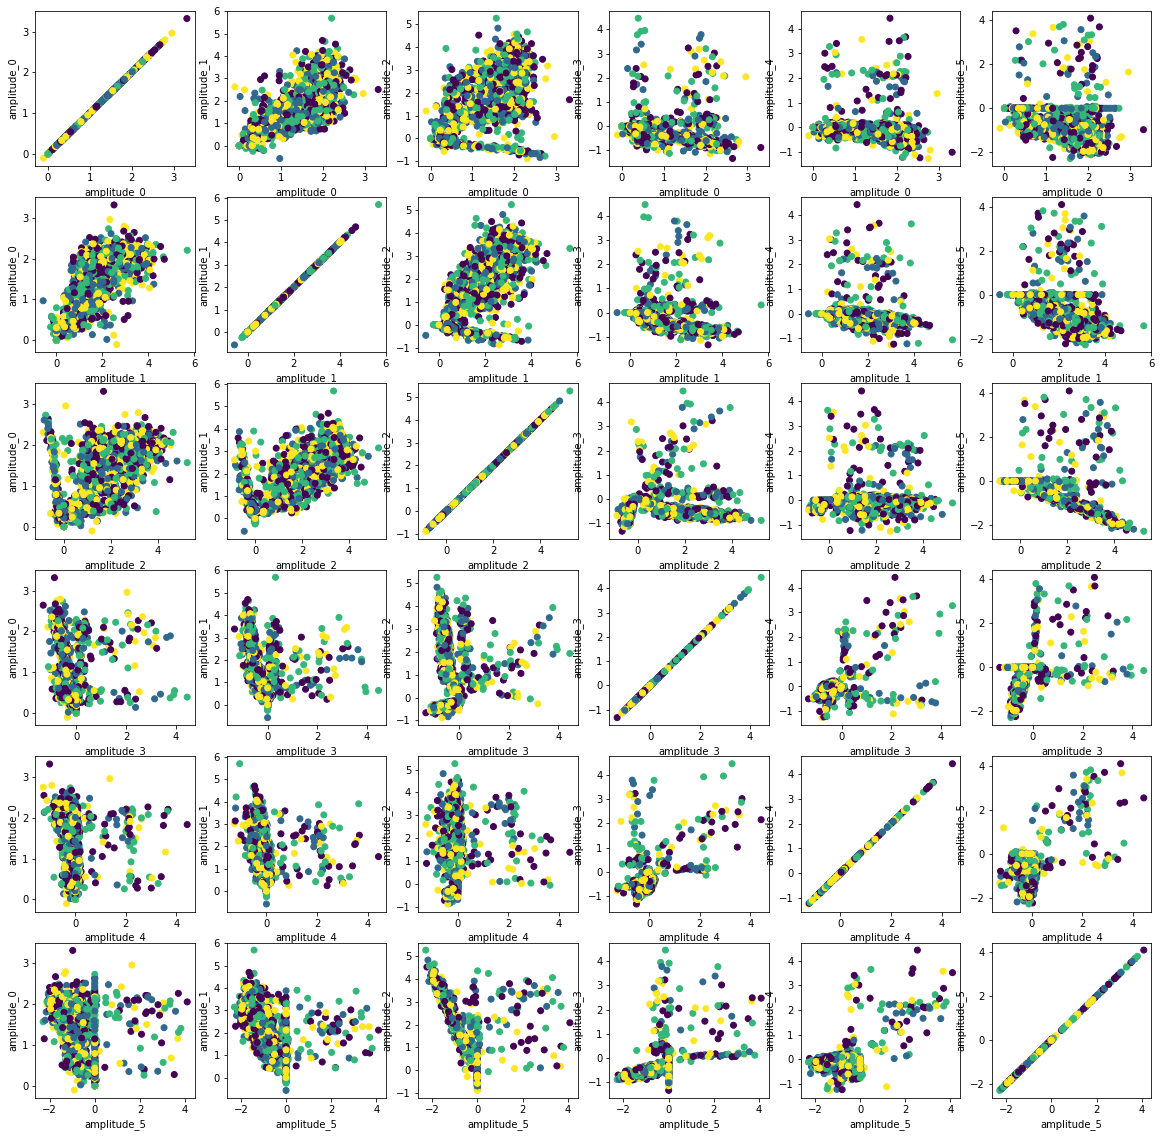

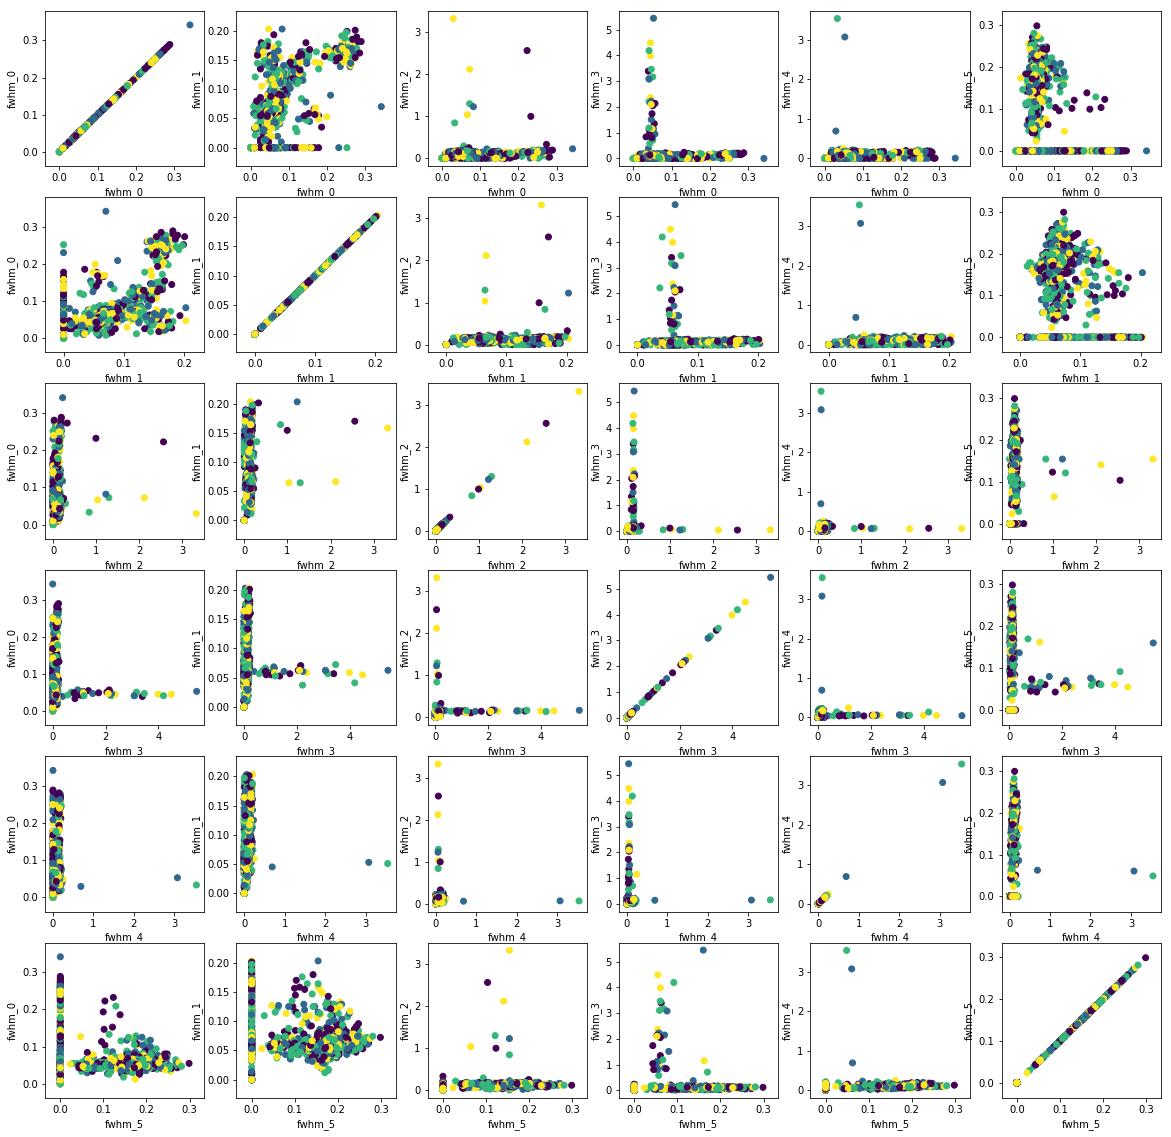

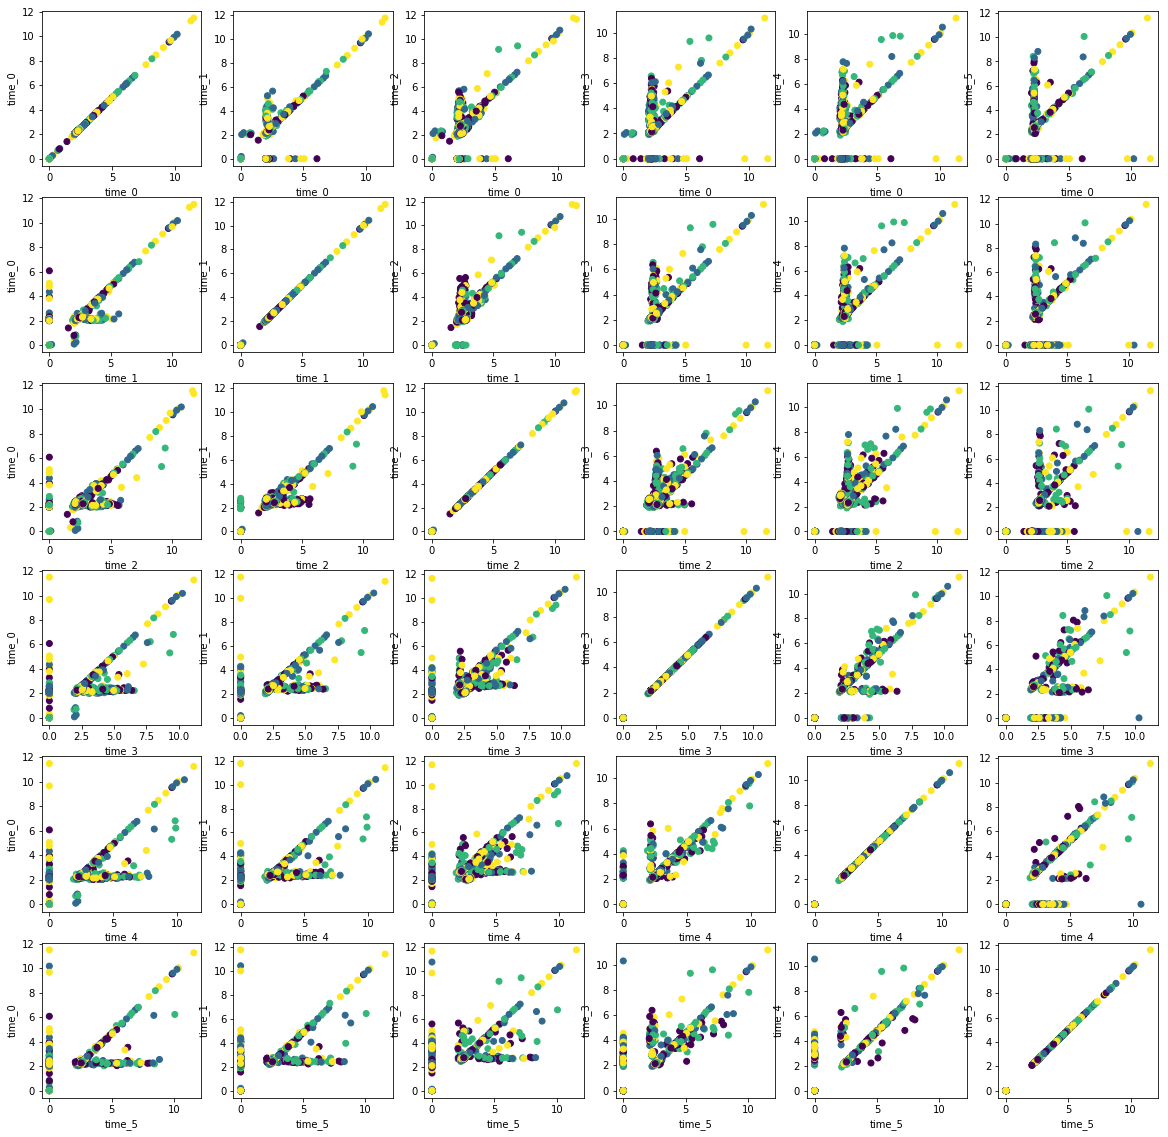

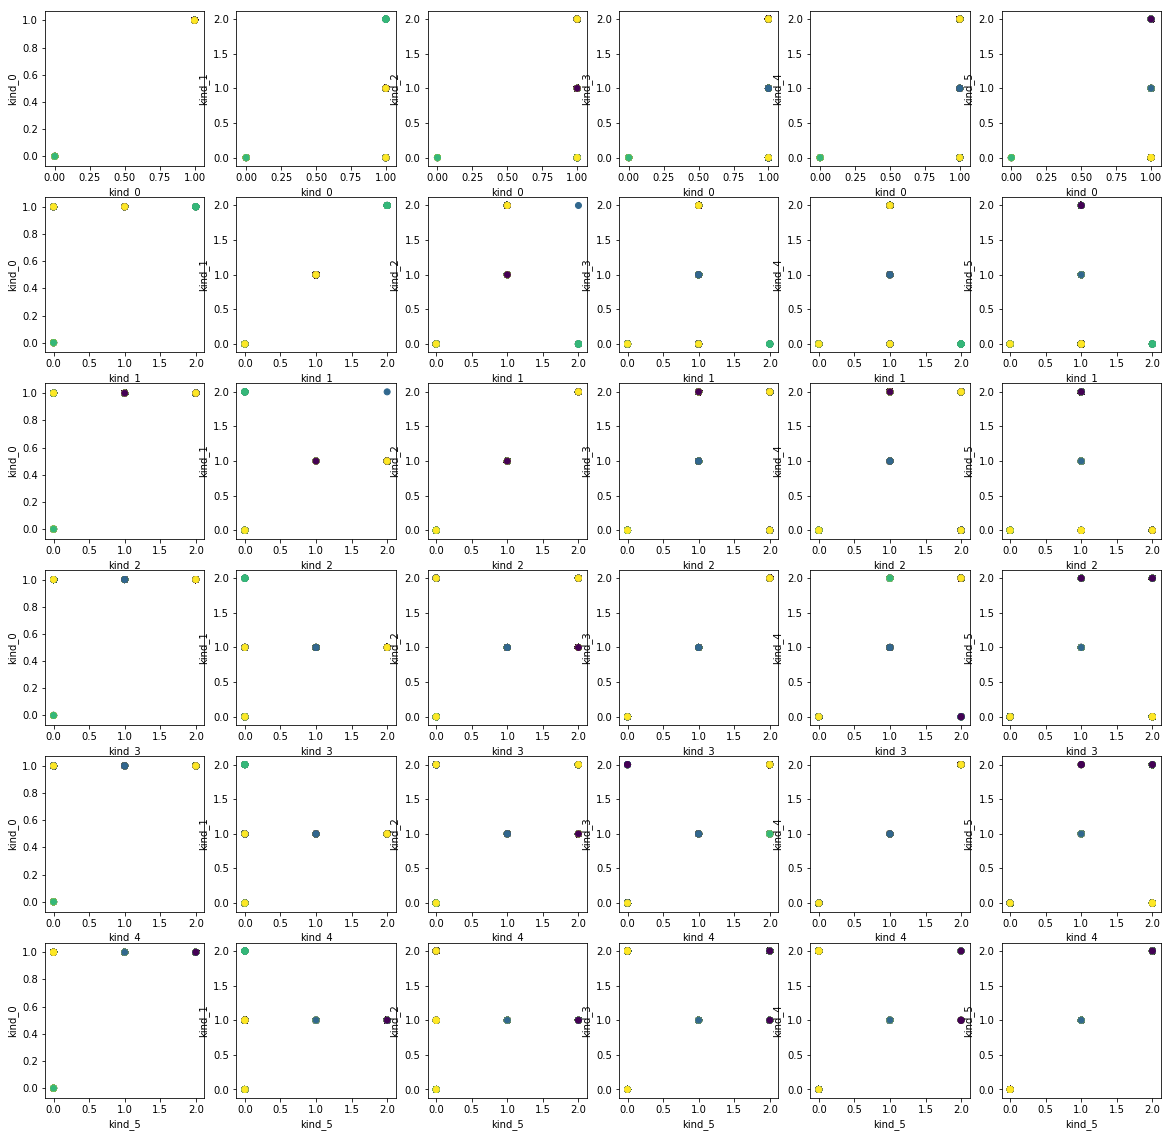

In [76]:
# Regrouppement variable par variable sur 5 élements
for var in list_var:
    plt.figure(figsize=(20,20))
    k=0
    for i in range(max_+1):
        for j in range(max_+1):
            k+=1
            plt.subplot(max_+1, max_+1, k)
            plt.scatter(X_train[var[i]], X_train[var[j]], c=predicted)
            plt.xlabel(var[i])
            plt.ylabel(var[j])

    plt.show()

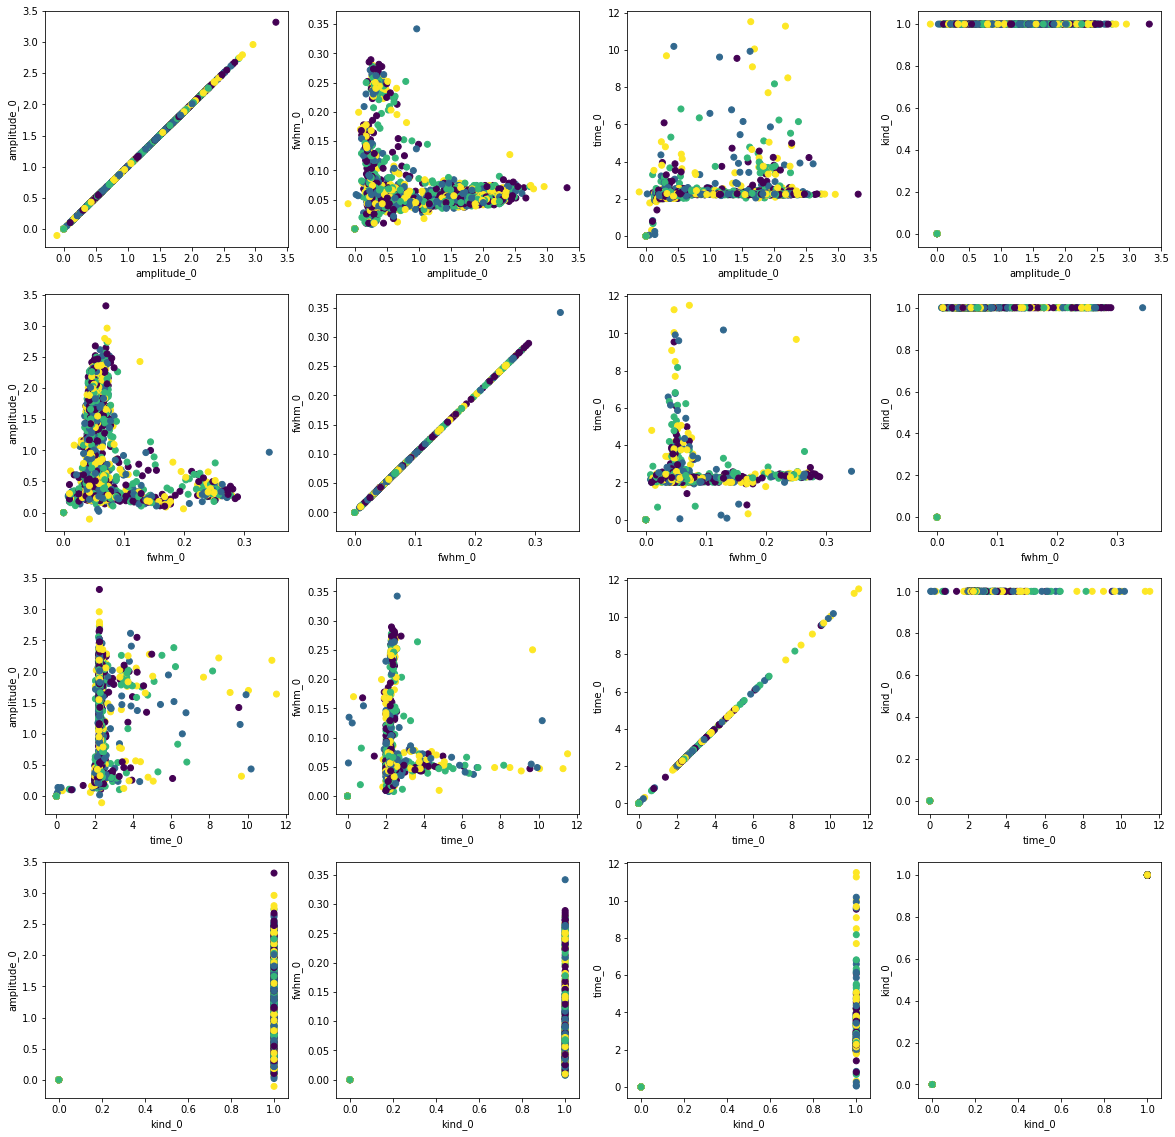

In [77]:
# Regroupement différente variables sur 1er élément
plt.figure(figsize=(20,20))
k=0
for i in list_var:
    for j in list_var:
        k+=1
        plt.subplot(len(list_var), len(list_var), k)
        plt.scatter(X_train[i[0]], X_train[j[0]], c=predicted)
        plt.xlabel(i[0])
        plt.ylabel(j[0])

plt.show()

#### Regression linéraire

In [80]:
rid = Ridge(random_state=42)
param = {
    "alpha" : [0.1, 0.5, 1.0, 2.0],
    "max_iter" : [1, 10, 100, 1000],
    "solver" : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    "tol" : [1, 0.1, 0.01, 0.001, 0.0001],
    "fit_intercept" : [True, False],
    "normalize" : [True, False],
    "copy_X" : [True, False],
    "n_jobs" : [1, 2]
}

In [ ]:
clf = GridSearchCV(rid, param, scoring='neg_mean_squared_error', n_jobs=2)
clf.fit(X_train, y_train)

In [ ]:
# Negate to have the MSE
-clf.best_score_

In [56]:
predicted = clf.predict(X_train)

In [57]:
# Score Train
mean_squared_error(y_train, predicted)

0.6513307887779114

In [59]:
predicted = clf.predict(X_test)

In [60]:
# Score Test
mean_squared_error(y_test, predicted)

1.9399323773908235e+21

In [63]:
# Concat y_test | ^y_test
pd.concat([y_test.reset_index(drop=True), pd.DataFrame(predicted)], axis=1)

,load_1,load_2,load_3,load_4,load_5,load_6,load_7,load_8,0,1,2,3,4,5,6,7
0,-0.226829,-1.060924,-0.282871,-0.800928,-1.210082,-0.088575,-0.045187,0.0,0.028581,0.115611,-0.472874,-0.716064,-0.568294,-0.222990,-0.327843,0.0
1,-0.148683,-1.057398,-0.502534,-0.792925,-0.411377,-0.088575,-0.045187,0.0,-0.032241,-0.152907,0.030227,-0.182600,-0.113339,0.022892,0.098154,0.0
2,1.038877,1.259546,1.427246,1.117380,1.525533,-0.088575,-0.045187,0.0,-0.456427,-0.370882,-0.158817,-0.108576,-0.041337,0.114480,0.264770,0.0
3,0.306812,0.904488,0.988392,1.055097,1.101605,-0.088575,-0.045187,0.0,-0.423607,-0.392487,-0.168453,-0.204243,-0.100880,0.010936,0.081325,0.0
4,-1.996546,-1.332490,-1.675379,-1.579462,-1.210082,-0.088575,-0.045187,0.0,-0.642257,-0.475507,-0.301098,-0.075756,-0.079659,-0.131796,0.095785,0.0
5,0.161682,1.073583,0.839071,0.799389,0.947564,-0.088575,-0.045187,0.0,0.233919,0.701793,0.542945,0.709914,0.601980,-0.095935,-0.278700,0.0
6,-0.259383,-1.004607,-0.613142,-0.126753,-0.241949,-0.088575,-0.045187,0.0,0.222906,-0.395976,-0.259771,-0.347201,-0.269557,-0.091225,0.132515,0.0
7,-3.078971,-2.049413,-1.090145,-1.579462,-1.210082,-0.088575,-0.045187,0.0,-0.535130,-0.380737,-0.504483,-0.562918,-0.451563,-0.071216,-0.105106,0.0
8,0.776202,1.196116,-1.675379,-1.579462,-1.210082,-0.088575,-0.045187,0.0,0.001848,-0.132552,-0.051124,-0.358465,-0.333782,-0.012143,-0.135946,0.0
9,0.882906,1.393956,0.959242,1.762110,1.208211,-0.088575,-0.045187,0.0,-0.209993,0.840387,0.282481,0.572807,0.253480,-0.171980,-0.009169,0.0


#### RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor(random_state=42)
param = {
    "n_estimators" : [250],
    "criterion" : ["mse", "mae"],
    "max_features" : [20, 30, 50, 80, "sqrt", "log2", 0.1, 0.5],
    "max_depth": [1, 5, 10, 15],
    "min_samples_split" : [1, 2, 5, 10],
    "min_samples_leaf" : [1, 2, 3],
    "oob_score" : [True, False],
    "warm_start" : [True, False],
    "bootstrap" : [True, False]
}

In [ ]:
clf = GridSearchCV(rfr, param, scoring='neg_mean_squared_error', n_jobs=2)
clf.fit(X_train, y_train)

In [ ]:
clf.best_params_

In [ ]:
clf.best_estimator_

In [ ]:
# Negate to have the MSE
-clf.best_score_

In [ ]:
predicted = clf.predict(X_train)

In [ ]:
# Score Train
mean_squared_error(y_train, predicted)

In [ ]:
predicted = clf.predict(X_test)

In [ ]:
# Score Test
mean_squared_error(y_test, predicted)